# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [29]:
# Change here using YOUR first and last names
fn1 = "pierre"
ln1 = "ablin"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_ablin_pierre_and_gramfort_alexandre.ipynb


In [30]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [31]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

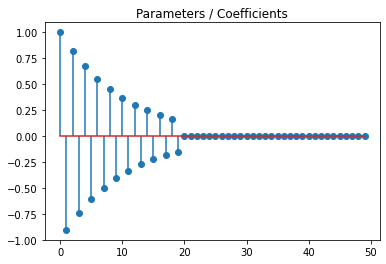

In [32]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [33]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [34]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [35]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    prx1 = x.copy()
    prx1[prx1 > lmbd] = prx1[prx1 > lmbd] - lmbd
    prx1[np.abs(prx1)<lmbd] = 0
    prx1[prx1 < -lmbd] = prx1[prx1 < -lmbd] + lmbd
    return prx1 # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x,ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    prx2 = x.copy()    
    prx2 = prx2*np.maximum(0, 1 - lmbd / np.linalg.norm(prx2, ord=2))
    
    return prx2 # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd/2 * np.linalg.norm(x, ord=2)**2


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

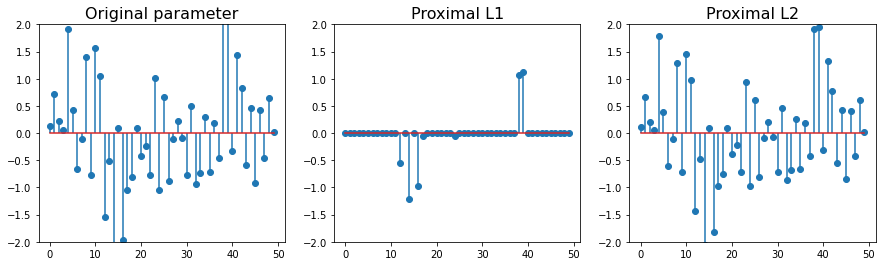

In [36]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>

</div>

In [37]:
A, b = simu_linreg(coefs)
#A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

In [64]:
def loss_linreg(x, A, b):
    """Least-squares loss"""
    n = A.shape[0]
    return (1/(2*n)) * np.linalg.norm(b-A@x, ord=2)**2

def grad_linreg(x, A, b):
    """Leas-squares gradient"""
    n = A.shape[0]
    return -(1/n) * A.T@(b-A@x)
    

def loss_logreg(x, A, b):
    """Logistic loss"""
    n = A.shape[0]
    return (1/n)*np.sum(np.log(1+np.exp(-np.expand_dims(b, axis =1)*A@x)))
    

def grad_logreg(x, A, b):
    """Logistic gradient"""
    n = A.shape[0]
    return (-1/n)*np.sum(b*A.T/(np.exp(np.expand_dims(b, axis =1)*A@x)+1),axis=1)

In [39]:
from scipy.optimize import check_grad
A, b = simu_linreg(coefs)
check_grad(loss_linreg,grad_linreg,np.random.randn(50),A,b)

1.7691635786611024e-06

In [40]:
A, b = simu_logreg(coefs) 
check_grad(loss_logreg,grad_logreg,np.random.randn(50),A,b)

1.2303430108619923e-07

## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [41]:
# TO BE COMPLETED
from numpy.linalg import norm as norm

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    L = (np.linalg.norm(A, ord=2))**2 / len(A)
    return L

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    L = (np.linalg.norm(A, ord=2))**2 / (len(A)*4.)
    return L
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    for k in range(n_iter + 1):
        x_new = prox_R(x - (1/step)*grad_f(x),lmbd)
        x = x_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [42]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_R(z - (1/step)*grad_f(z),lmbd)
        t_new = (1+np.sqrt(1+4*t**2))/2
        z = x_new + ((t-1)/(t_new)) * (x_new - x)
        x=x_new
        t=t_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [43]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [44]:
A, b = simu_linreg(coefs)
def f(x): return loss_linreg(x, A, b)
def grad_f(x): return grad_linreg(x, A, b)

x_min, obj_min, err_min = APGD(x0, f, grad_f, L2_norm, prox_L2, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)

print("err_min : ",err_min[-1])
print("\nx_min : ",x_min)
print("\nobj_min : ",obj_min[-1])

err_min :  0.13305213173739897

x_min :  [ 9.64e-01 -8.97e-01  8.24e-01 -6.50e-01  6.57e-01 -5.39e-01  4.56e-01
 -4.38e-01  4.45e-01 -4.65e-01  3.87e-01 -2.86e-01  2.05e-01 -2.07e-01
  2.65e-01 -2.28e-01  1.64e-01 -2.08e-01  1.91e-01 -7.41e-02 -3.96e-02
 -9.84e-03  5.92e-02 -2.34e-02 -1.30e-02  5.02e-02 -6.12e-02  1.23e-02
  5.27e-02 -5.48e-02 -3.04e-02  6.70e-02 -1.65e-02  6.63e-03 -5.30e-03
 -6.01e-02  5.34e-02  3.82e-02 -2.01e-02 -1.18e-02  8.20e-03 -3.95e-02
  2.94e-02  2.28e-02 -6.08e-02  3.84e-02  6.07e-04 -1.64e-02  1.64e-02
  6.71e-03]

obj_min :  0.5166210837190647


In [45]:
x_pgd, obj_pgd, err_pgd = PGD(x0, f, grad_f, L2_norm, prox_L2, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=1000, x_true=x_min, verbose=False)

print("err_min : ",err_pgd[-1])
print("\nx_min : ",x_pgd)
print("\nobj_min : ",obj_pgd[-1])

err_min :  1.7156863414970634e-07

x_min :  [ 9.64e-01 -8.97e-01  8.24e-01 -6.50e-01  6.57e-01 -5.39e-01  4.56e-01
 -4.38e-01  4.45e-01 -4.65e-01  3.87e-01 -2.86e-01  2.05e-01 -2.07e-01
  2.65e-01 -2.28e-01  1.64e-01 -2.08e-01  1.91e-01 -7.41e-02 -3.96e-02
 -9.84e-03  5.92e-02 -2.34e-02 -1.30e-02  5.02e-02 -6.12e-02  1.23e-02
  5.27e-02 -5.48e-02 -3.04e-02  6.70e-02 -1.65e-02  6.63e-03 -5.30e-03
 -6.01e-02  5.34e-02  3.82e-02 -2.01e-02 -1.18e-02  8.20e-03 -3.95e-02
  2.94e-02  2.28e-02 -6.08e-02  3.84e-02  6.06e-04 -1.64e-02  1.64e-02
  6.71e-03]

obj_min :  0.5166210848076319


In [46]:
x_apgd, obj_apgd, err_apgd = APGD(x0, f, grad_f, L2_norm, prox_L2, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=1000, x_true=x_min, verbose=False)

print("err_min : ",err_apgd[-1])
print("\nx_min : ",x_apgd)
print("\nobj_min : ",obj_apgd[-1])

err_min :  1.7156863420088137e-07

x_min :  [ 9.64e-01 -8.97e-01  8.24e-01 -6.50e-01  6.57e-01 -5.39e-01  4.56e-01
 -4.38e-01  4.45e-01 -4.65e-01  3.87e-01 -2.86e-01  2.05e-01 -2.07e-01
  2.65e-01 -2.28e-01  1.64e-01 -2.08e-01  1.91e-01 -7.41e-02 -3.96e-02
 -9.84e-03  5.92e-02 -2.34e-02 -1.30e-02  5.02e-02 -6.12e-02  1.23e-02
  5.27e-02 -5.48e-02 -3.04e-02  6.70e-02 -1.65e-02  6.63e-03 -5.30e-03
 -6.01e-02  5.34e-02  3.82e-02 -2.01e-02 -1.18e-02  8.20e-03 -3.95e-02
  2.94e-02  2.28e-02 -6.08e-02  3.84e-02  6.06e-04 -1.64e-02  1.64e-02
  6.71e-03]

obj_min :  0.5166210848076319


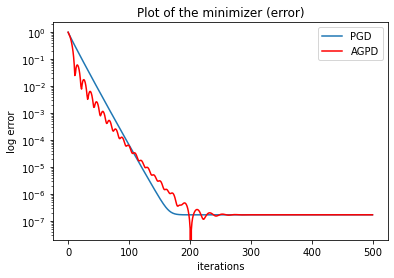

In [47]:
plt.plot(err_pgd[:500], label='PGD')
plt.plot(err_apgd[:500],c='r',label = 'AGPD')
plt.ylabel('log error')
plt.yscale("log")
plt.xlabel("iterations")
plt.legend()
plt.title("Plot of the minimizer (error)")
plt.show()

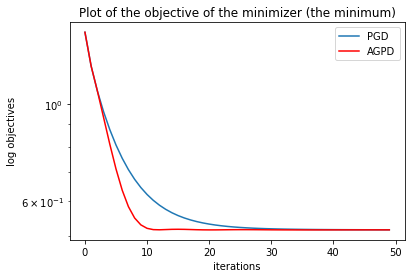

In [48]:
plt.plot(obj_pgd[:50], label='PGD')
plt.plot(obj_apgd[:50],c='r',label = 'AGPD')
plt.ylabel('log objectives')
plt.yscale("log")
plt.xlabel("iterations")
plt.title("Plot of the objective of the minimizer (the minimum)")
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

In [49]:
################################ FIRST Q ################################

### For Linear Regression and Regulizer 2

In [50]:
x_minpgd, obj_minpgd, err_minpgd = PGD(x0, f, grad_f, L2_norm, prox_L2, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=1000, x_true=coefs, verbose=False)

(-1.0, 1.0)

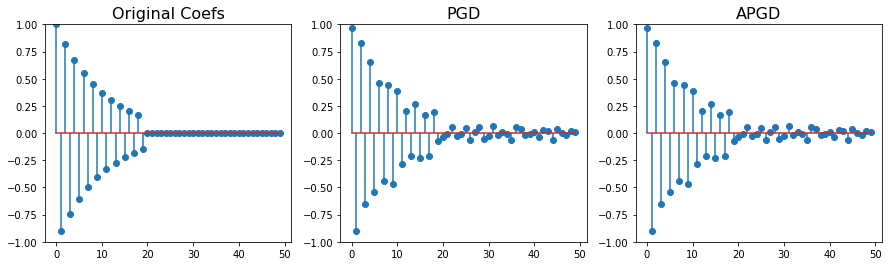

In [51]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("Original Coefs", fontsize=16)
plt.ylim([-1, 1])
plt.subplot(1, 3, 2)
plt.stem(x_pgd)
plt.title("PGD", fontsize=16)
plt.ylim([-1, 1])
plt.subplot(1, 3, 3)
plt.stem(x_min)
plt.title("APGD", fontsize=16)
plt.ylim([-1, 1])

### For Linear Regression and Regulizer 1

In [57]:
x_minpgd2, obj_minpgd2, err_minpgd2 = PGD(x0, f, grad_f, L1_norm, prox_L1, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=1000, x_true=coefs, verbose=False)

In [58]:
x_apgd2, obj_apgd2, err_apgd2 = APGD(x0, f, grad_f, L1_norm, prox_L1, smoothness_const_linreg(A), 
     lmbd=lmbd, n_iter=1000, x_true=x_min, verbose=False)

(-1.0, 1.0)

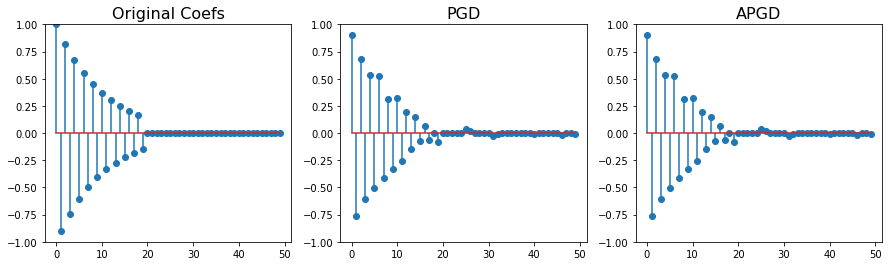

In [59]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("Original Coefs", fontsize=16)
plt.ylim([-1, 1])
plt.subplot(1, 3, 2)
plt.stem(x_minpgd2)
plt.title("PGD", fontsize=16)
plt.ylim([-1, 1])
plt.subplot(1, 3, 3)
plt.stem(x_apgd2)
plt.title("APGD", fontsize=16)
plt.ylim([-1, 1])

In [52]:
################################ SECOND Q ################################

### For Linear Regression and Regulizer 2

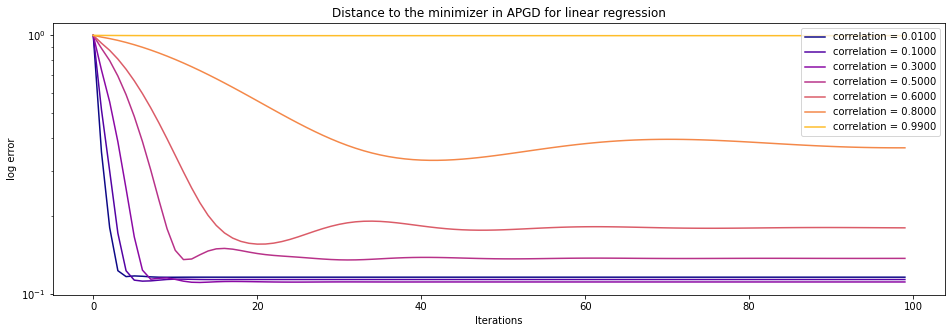

In [53]:
lst_corr = [0.01,0.1,0.3,0.5,0.6,0.8,0.99]

cm = plt.get_cmap("plasma")
colors = [cm(x) for x in np.arange(start=0, stop=1, step=1./len(lst_corr))]
n_max = 100

# Linear Regression and FISTA
plt.figure(figsize=(16, 5))
for i, correlation in enumerate(lst_corr):
    A, b = simu_linreg(coefs, corr=correlation)
    L = smoothness_const_linreg(A)

    def f(x): return loss_linreg(x, A, b)

    def grad_f(x): return grad_linreg(x, A, b)
    _, _, err_fista_corr = APGD(x0, f, grad_f, L2_norm, prox_L2,
                            smoothness_const_linreg(A), lmbd, n_iter=1000, x_true=coefs, verbose=False)
    plt.plot(range(n_max), err_fista_corr[:n_max], '-',
             label="correlation = " + "%0.4f" % correlation, color=colors[i])

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("log error")
plt.title("Distance to the minimizer in APGD for linear regression")
plt.yscale("log")
plt.show()

In [54]:
################################ THIRD Q ################################

### For Logistic Regression and Regulizer 1

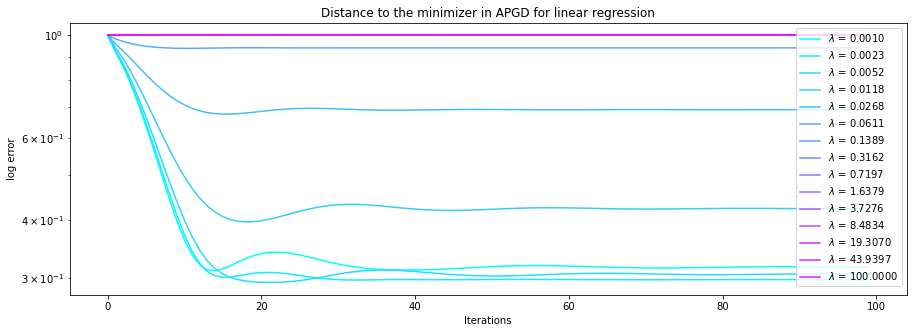

In [66]:
penalizations = np.logspace(start=-3, stop=2, base=10.0, num=15)
xx_apgd = np.zeros((len(penalizations), n_features))

cm = plt.get_cmap("cool")
colors = [cm(x)
          for x in np.arange(start=0, stop=1, step=1./len(penalizations))]

n_max = 100

def f2(x): return loss_logreg(x, A, b)
def grad_f2(x): return grad_logreg(x, A, b)

# For linear regression and APGD
fig, ax = plt.subplots(figsize=(15, 5))

A, b = simu_logreg(coefs)
L = smoothness_const_loreg(A)

for i, penalization in enumerate(penalizations):
    xx_apgd[i], _, err_apgd = APGD(x0, f2, grad_f2, L1_norm, prox_L1,
                            smoothness_const_loreg(A), penalization, n_iter=1000, x_true=coefs, verbose=False)
    ax.plot(range(n_max), err_apgd[:n_max], '-',
                label="$\lambda$ = " + "%0.4f" % penalization, color=colors[i])

ax.legend(loc="upper right")
ax.set_xlabel("Iterations")
ax.set_ylabel("log error")
ax.set_title("Distance to the minimizer in APGD for linear regression")
ax.set_yscale("log")